In this final notebook, we will have a look at the integrability of ML using the NTN channel models. To do that, we will reuse the existing implementation of the NeuralReceiver provided by Sionna https://nvlabs.github.io/sionna/phy/tutorials/Neural_Receiver.html.

The used papers are the paper on a NN based SIMO receiver
DeepRx: Fully convolutional deep learning receiver, submitted to IEEE Transactions on Wireless Communications. arXiv preprint:1711.05101, 2020.
This has already been implemented in a Sionna Tutorial:
Neural Receiver for OFDM SIMO Systems, https://nvlabs.github.io/sionna/examples/Neural_Receiver.html
The extension for the MIMO case is in the paper:
Korpi, D., Honkala, M., Huttunen, J.M., & Starck, V. (2020). DeepRx MIMO: Convolutional MIMO Detection with Learned Multiplicative Transformations. ICC 2021 - IEEE International Conference on Communications, 1-7.

As the previous examples have shown, the NTN channels are very challenging, especially without perfect CSI and in presense of doppler spread. Thus, ML based solutions are a promissing solution. Additionally, despite this notebook reusing an existing NN already implemented in Sionna for the existing code, this actually only effects a small part of the code and could be done with any existing NN in a Tensorflow compatible format.

In [15]:
#General imports
import sionna.phy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Setup to use GPU
import os
gpu_num = 0 # Use "" to use the CPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


#Specific components used in this simulation
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.phy.mimo import StreamManagement
from sionna.phy.channel.tr38811 import AntennaArray, DenseUrban, Urban, SubUrban
from sionna.phy.utils import ebnodb2no, sim_ber, log10, insert_dims, expand_to_rank
from sionna.phy.fec.ldpc.encoding import LDPC5GEncoder
from sionna.phy.fec.ldpc.decoding import LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, BinarySource
from sionna.phy.channel import OFDMChannel
from sionna.phy import Block

#Used to track time as save results
import time
import pickle

from sionna.phy.channel.tr38811.utils import gen_single_sector_topology as gen_ntn_topology

#Imports to build the Neural Networks
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

In [ ]:
#System setup parameters
num_conv_channels = 128
num_bits_per_symbol = 2
train_new_model = False
evaluate_model = True
model_weights_path = "ntn_deeprx_model_weights"

ebno_db_min = -5.0
ebno_db_max = 0.5
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                    ebno_db_max, # Max SNR for evaluation
                    0.5) # Step

The structure uses a repeated architecture using so called residual blocks.

In [17]:
class ResidualBlock(Layer):
    r"""
    This Keras layer implements a convolutional residual block made of two convolutional layers with ReLU activation, layer normalization, and a skip connection.
    The number of convolutional channels of the input must match the number of kernel of the convolutional layers ``num_conv_channel`` for the skip connection to work.

    Input
    ------
    : [batch size, num time samples, num subcarriers, num_conv_channel], tf.float
        Input of the layer

    Output
    -------
    : [batch size, num time samples, num subcarriers, num_conv_channel], tf.float
        Output of the layer
    """

    def build(self, input_shape):

        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z)
        # Skip connection
        z = z + inputs

        return z

The Neural receiver which takes the received IQ symbols and calculates the corresponding LLRs for the demapper is implemented in the following block.

In [18]:
class NeuralReceiver(Layer):
    r"""
    Keras layer implementing a residual convolutional neural receiver.

    This neural receiver is fed with the post-DFT received samples, forming a resource grid of size num_of_symbols x fft_size, and computes LLRs on the transmitted coded bits.
    These LLRs can then be fed to an outer decoder to reconstruct the information bits.

    As the neural receiver is fed with the entire resource grid, including the guard bands and pilots, it also computes LLRs for these resource elements.
    They must be discarded to only keep the LLRs corresponding to the data-carrying resource elements.

    Input
    ------
    y : [batch size, num rx antenna, num ofdm symbols, num subcarriers], tf.complex
        Received post-DFT samples.

    no : [batch size], tf.float32
        Noise variance. At training, a different noise variance value is sampled for each batch example.

    Output
    -------
    : [batch size, num ofdm symbols, num subcarriers, num_bits_per_symbol]
        LLRs on the transmitted bits.
        LLRs computed for resource elements not carrying data (pilots, guard bands...) must be discarded.
    """

    def build(self, input_shape):

        # Input convolution
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[3,3],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[3,3],
                                   padding='same',
                                   activation=None)

    def call(self, y, no):

        # Feeding the noise power in log10 scale helps with the performance
        no = log10(no)

        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        # z : [batch size, num ofdm symbols, num subcarriers, 2*num rx antenna + 1]
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)

        return z

We implement the end to end model in the following cell. To save resources while training, the decoding is only exectued during the inference, during training the system is optimized by comparing the LLRs. If deep_rx is False, the model instead builds a traditional communications system with or without perfect csi. 

In [19]:
class FullE2EModel(Block):
    """Simulate OFDM MIMO transmissions over a 3GPP 38.811 model.
    """
    def __init__(self, scenario, perfect_csi, doppler_enabled, elevation_angle = 80.0, deep_rx = False, training=False):
        super().__init__()
        self._scenario = scenario
        self._perfect_csi = perfect_csi
        self._training = training

        # Internally set parameters
        self._carrier_frequency = 30.0e9
        self._fft_size = 128
        self._subcarrier_spacing = 30e3
        self._num_ofdm_symbols = 14
        self._cyclic_prefix_length = 20
        self._pilot_ofdm_symbol_indices = [2, 11]
        self._num_bs_ant = 8
        self._num_ut = 1
        self._num_ut_ant = 1
        self._num_bits_per_symbol = 2
        self._coderate = 0.5
        self._direction = "uplink"
        self._sat_height = 600000.0
        self._deep_rx = deep_rx

        # Create an RX-TX association matrix
        # rx_tx_association[i,j]=1 means that receiver i gets at least one stream
        # from transmitter j. Depending on the transmission direction (uplink or downlink),
        # the role of UT and BS can change.
        bs_ut_association = np.zeros([1, self._num_ut])
        bs_ut_association[0, :] = 1
        self._rx_tx_association = bs_ut_association
        self._num_tx = self._num_ut
        self._num_streams_per_tx = self._num_ut_ant

        # Setup an OFDM Resource Grid
        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing=self._subcarrier_spacing,
                                num_tx=self._num_tx,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                pilot_pattern="kronecker",
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices)

        # Setup StreamManagement
        self._sm = StreamManagement(self._rx_tx_association, self._num_streams_per_tx)

        # Configure antenna arrays
        self._ut_array = AntennaArray(
                                num_rows=1,
                                num_cols=self._num_ut_ant,
                                polarization="single",
                                polarization_type="V",
                                antenna_pattern="omni",
                                carrier_frequency=self._carrier_frequency)

        self._bs_array = AntennaArray(num_rows=1,
                                    num_cols=int(self._num_bs_ant/2),
                                    polarization="dual",
                                    polarization_type="cross",
                                    antenna_pattern="38.901",
                                    carrier_frequency=self._carrier_frequency)

        # Configure the channel model
        if scenario == "dur":
            self._channel_model = DenseUrban(carrier_frequency=self._carrier_frequency,
                                    ut_array=self._ut_array,
                                    bs_array=self._bs_array,
                                    direction=self._direction,
                                    elevation_angle=elevation_angle,
                                    doppler_enabled=doppler_enabled)
        elif scenario == "sur":
            self._channel_model = SubUrban(carrier_frequency=self._carrier_frequency,
                                    ut_array=self._ut_array,
                                    bs_array=self._bs_array,
                                    direction=self._direction,
                                    elevation_angle=elevation_angle,
                                    doppler_enabled=doppler_enabled)
        elif scenario == "urb":
            self._channel_model = Urban(carrier_frequency=self._carrier_frequency,
                                    ut_array=self._ut_array,
                                    bs_array=self._bs_array,
                                    direction=self._direction,
                                    elevation_angle=elevation_angle,
                                    doppler_enabled=doppler_enabled)

        # Instantiate other building blocks
        self._binary_source = BinarySource()


        self._n = int(self._rg.num_data_symbols*self._num_bits_per_symbol) # Number of coded bits
        self._k = int(self._n*self._coderate)                              # Number of information bits
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._encoder = LDPC5GEncoder(self._k, self._n)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)

        self._ofdm_channel = OFDMChannel(self._channel_model, self._rg, add_awgn=True,
                                        normalize_channel=True, return_channel=True)

        ## Receiver either with perf csi, without perf csi and deeprx
        if self._perfect_csi:
            self._remove_nulled_subcarriers = RemoveNulledSubcarriers(self._rg)
        else:
            self._ls_est = LSChannelEstimator(self._rg, interpolation_type="nn")

        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)

        if self._deep_rx:
            self._neural_receiver = NeuralReceiver()
            self._rg_demapper = ResourceGridDemapper(self._rg, self._sm)

        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    def new_topology(self, batch_size):
        topology = gen_ntn_topology(batch_size=batch_size, num_ut=self._num_ut, scenario=self._scenario)
        self._channel_model.set_topology(*topology)
        
    @tf.function
    def call(self, batch_size, ebno_db):
        self.new_topology(batch_size)
        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate)

        if self._training:
            c = self._binary_source([batch_size, self._num_tx, self._num_streams_per_tx, self._n])
        else:
            b = self._binary_source([batch_size, self._num_tx, self._num_streams_per_tx, self._k])
            c = self._encoder(b)

        x = self._mapper(c)
        x_rg = self._rg_mapper(x)

        no_ = expand_to_rank(no, tf.rank(x_rg))
        y, h = self._ofdm_channel(x_rg, no_)

        if not self._deep_rx:
            if self._perfect_csi:
                h_hat = self._remove_nulled_subcarriers(h)
                err_var = 0.0
            else:
                h_hat, err_var = self._ls_est(y, no)
            
            x_hat, no_eff = self._lmmse_equ(y, h_hat, err_var, no)
            llr = self._demapper(x_hat, no_eff)   

        elif self._deep_rx:
            y = tf.squeeze(y, axis=1)
            llr = self._neural_receiver(y, no)
            llr = insert_dims(llr, 2, 1) # Reshape the input to fit what the resource grid demapper is expected
            llr = tf.reshape(llr, [batch_size, 1, 1, self._rg.num_ofdm_symbols, self._rg.fft_size, 2])

            llr = self._rg_demapper(llr) # Extract data-carrying resource elements. The other LLrs are discarded
            llr = tf.reshape(llr, [batch_size, self._num_tx, self._num_streams_per_tx, self._n]) # Reshape the LLRs to fit what the outer decoder is expected


        # Outer coding is not needed if the information rate is returned
        if self._training:
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
            return rate
        else:
            b_hat = self._decoder(llr)
            return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

We train the model and save the progress every 100 iterations.

In [ ]:
model = FullE2EModel(scenario="dur", perfect_csi=False, doppler_enabled=False, elevation_angle = 80.0, deep_rx = True, training=True)
training_batch_size = 128
num_training_iterations = 30000
optimizer = tf.keras.optimizers.Adam()

for i in range(num_training_iterations):
    # Sampling a batch of SNRs
    ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
    # Forward pass
    with tf.GradientTape() as tape:
        rate = model(training_batch_size, ebno_db)
        # Tensorflow optimizers only know how to minimize loss function.
        # Therefore, a loss function is defined as the additive inverse of the BMD rate
        loss = -rate
    # Computing and applying gradients
    weights = tape.watched_variables()
    grads = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(grads, weights))
    # Periodically printing the progress
    if i % 100 == 0:
        print('Iteration {}/{}  Rate: {:.4f} bit'.format(i, num_training_iterations, rate.numpy()), end='\r')
        with open(model_weights_path, 'wb') as f:
            pickle.dump(weights, f)

We evaluate the model by executing inference with the trained weights. We save the results at the end.

In [ ]:
SIMS = {
    "ebno_db" : list(np.arange(-5, 0.5, 0.5)),
    "ber" : [],
    "bler" : [],
    "duration" : None
}

model = FullE2EModel(scenario="dur", perfect_csi=False, doppler_enabled=False, elevation_angle = 80.0, deep_rx = True, training=False)

# Run one inference to build the layers and loading the weights
model(1, tf.constant(10.0, tf.float32))
with open(model_weights_path, 'rb') as f:
    weights = pickle.load(f)

for i, w in enumerate(weights):
    model._neural_receiver.weights[i].assign(w)


start = time.time()

# Evaluations
ber,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)
SIMS["ber"].append(list(ber.numpy()))
SIMS["bler"].append(list(bler.numpy()))

SIMS["duration"] = time.time() -  start
print("Simulations took ", SIMS["duration"])

with open('ntn_deeprx_sim_results.pkl', 'wb') as f:
    pickle.dump(SIMS, f)

As the simulations might take a while, the following cell saves the results directly

In [ ]:
ber = [0.00017755126953125, 0.00011601765950520834, 5.492655436197917e-05, 2.7776082356770834e-05, 1.6774495442708332e-05, 7.802327473958333e-06, 3.6824544270833335e-06, 5.223592122395833e-06, 4.786173502604166e-06, 1.3682047526041668e-06, 4.933675130208333e-07]
bler = [0.0014140625, 0.0008125, 0.00046875, 0.0002421875, 0.000109375, 7.03125e-05, 3.125e-05, 4.6875e-05, 2.34375e-05, 7.8125e-06, 7.8125e-06]
ebno_dbs = list(np.arange(-5, 0.5, 0.5))

and plot the results

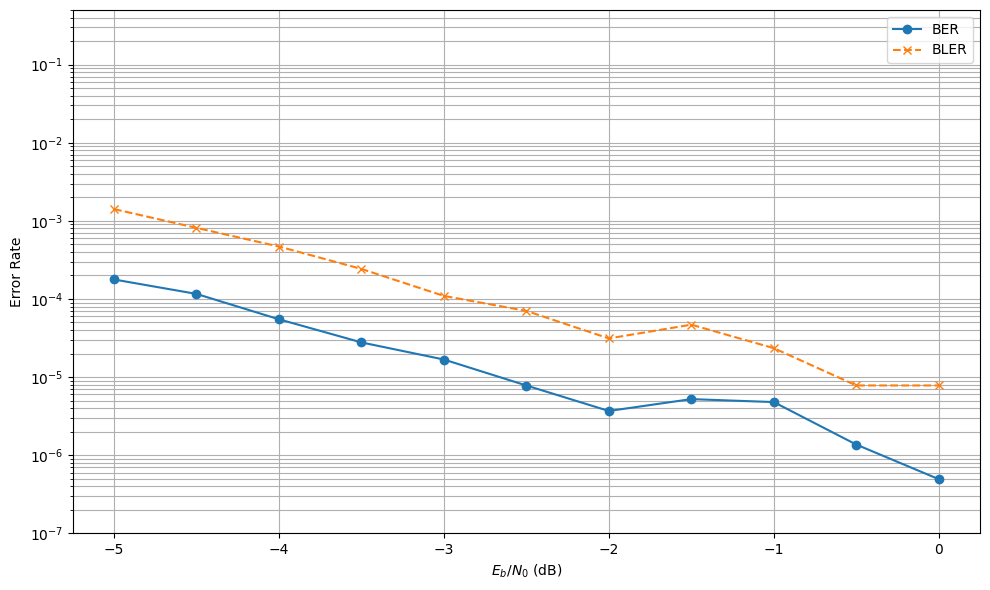

In [ ]:
plt.figure(figsize=(10,6))
# Baseline - Perfect CSI
plt.semilogy(ebno_dbs, ber, 'o-', c=f'C0', label=f'BER')
# Baseline - LS Estimation
plt.semilogy(ebno_dbs, bler, 'x--', c=f'C1', label=f'BLER')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("Error Rate")
plt.grid(which="both")
plt.ylim((1e-7, 0.5))
plt.legend()
plt.tight_layout()


We observe that the Bit Error Rate (BER) and Block Error Rate (BLER) both improve significantly with increasing E_b/N_o, showing that the DeepRx is effective even under challenging NTN conditions without perfect CSI.